# MNIST ODIN

In [1]:
pip install emnist

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler

from emnist import list_datasets, extract_training_samples

In [3]:
if False: # only for JupyterLab with GPUs environment
    import sys
    sys.path.insert(0, '/notebooks/')
    sys.path.insert(0, '../')
    from CapsuleLib.utils import gpu_config
    gpuid = gpu_config(False, True)

## Hyperparameters

In [4]:
TRAINING = False
BATCH_SIZE = 64
EPOCHS = 10

## Data preparation

In [5]:
# Load MNIST digits
x_digits, y_digits = extract_training_samples('digits')
x_digits = x_digits.astype("float32") / 255.0
x_digits = np.reshape(x_digits, (*x_digits.shape, 1))

# Load EMNIST letters
x_letters, y_letters = extract_training_samples('letters')
x_letters = x_letters[(y_letters!=12)&(y_letters!=15)&(y_letters!=9)] # exclude I, l and O 
y_letters = y_letters[(y_letters!=12)&(y_letters!=15)&(y_letters!=9)] # exclude I, l and O 
x_letters = x_letters.astype("float32") / 255.0
x_letters = np.reshape(x_letters, (*x_letters.shape, 1)) 

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(x_digits, y_digits, test_size=0.2, random_state=0)

# Data generators
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

train_gen = datagen.flow(x_train, tf.keras.utils.to_categorical(y_train), batch_size=BATCH_SIZE)
val_gen = datagen.flow(x_val, tf.keras.utils.to_categorical(y_val), batch_size=BATCH_SIZE)
ood_gen = datagen.flow(x_letters, tf.keras.utils.to_categorical(y_letters), batch_size=BATCH_SIZE)

## Helper functions

In [10]:
def get_model(temp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())    
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(512,activation="relu"))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Lambda(lambda x: x / temp))
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

def train_model(model, train_gen, val_gen):
    
    def scheduler(epoch, lr):
        return 0.7*lr

    lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    # Fit the model
    model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=[lr_scheduler])
    
    return model # Return trained model

def get_msp(image_batch):
    softmax_probs = model.predict(image_batch)
    return 1-np.max(softmax_probs, axis=1)

def perturb_images(images, epsilon=0.002):
    
    test_ds_var = tf.Variable(images, trainable=True)

    with tf.GradientTape() as tape:
        tape.watch(test_ds_var)
        loss = -tf.reduce_mean(tf.reduce_max(model(test_ds_var, training=False), axis=1))

    gradients = tf.math.greater_equal(tape.gradient(loss, test_ds_var), 0)
    gradients = tf.cast(gradients, tf.float32)
    gradients = (gradients - 0.5) * 2

    static_tensor = tf.convert_to_tensor(test_ds_var) - epsilon * gradients
    static_tensor = tf.clip_by_value(static_tensor, 0., 255.)
    
    return static_tensor

def plot_hist(val_generator, test_generator, runs=100, epsilon=0):
    msp_list = []
    for generator in [val_generator, test_generator]:
        msp = []
        for n in range(runs):
            batch = generator.next()[0]
            msp = np.concatenate([msp,get_msp(perturb_images(batch, epsilon))])
        msp_list.append(msp)
    
    fig, ax = plt.subplots(figsize=(6,6))
    logbins = np.logspace(-6.5,0,50)
    ax.hist(msp_list[0], bins=logbins, alpha=0.4, label="Validation", color="blue")
    ax.hist(msp_list[1], bins=logbins, alpha=0.5, label="OOD", color="orange")
    #ax.axvline(x=THRESHOLD, color='r')
    plt.xlabel("$1-\mathcal{S}(x)$")
    plt.xscale('log')
    plt.yticks([])
    plt.legend()
    fig.show()
    
def plot_roc(runs=100, label="MSP", epsilon=0):
    
    y_pred, y_true, y_probs = [], [], []
    
    for n in range(runs):
        
        val_batch = perturb_images(val_gen.next()[0], epsilon)
        test_batch = perturb_images(ood_gen.next()[0], epsilon)
        
        y_probs = np.concatenate([y_probs, get_msp(val_batch)])
        y_true = np.concatenate([y_true, np.zeros(BATCH_SIZE)])
        
        y_probs = np.concatenate([y_probs, get_msp(test_batch)])
        y_true = np.concatenate([y_true, np.ones(BATCH_SIZE)])
        
    roc_values = []
    threshold_range = np.concatenate([[0.],np.logspace(-8,-6,30), np.logspace(-6,-2,60), np.logspace(-2,0,30)])
    
    for threshold in threshold_range:
        
        y_pred = np.where(y_probs >= threshold, 1, 0)
        
        sensitivity = np.sum(np.logical_and(y_pred,y_true))/np.sum(y_true)
        specificity = np.sum(~np.logical_or(y_pred,y_true)/(y_pred.size-np.sum(y_true)))
                             
        roc_values.append((1-specificity, sensitivity))
        
    revspec, sens = zip(*roc_values)
    revspec, sens = np.array(revspec), np.array(sens)
    spec = 1-np.array(revspec)

    print("AUROC:",np.abs(np.trapz(spec, np.array(sens))))
    print("FPR80:",revspec[np.argmin(np.abs(sens-0.85))])
    print("FPR90:",revspec[np.argmin(np.abs(sens-0.90))])
    print("FPR95:",revspec[np.argmin(np.abs(sens-0.95))])
                             
    plt.step(*list(zip(*roc_values)), where='post', label=label)
    plt.xlabel("1 - specificity")
    plt.ylabel("sensitivity")
    plt.plot([0,1], [0,1], '--', color="gray", label='random', linewidth=2)
    plt.legend()
    plt.title("ROC")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

## ODIN (T=1)

### Classifier model

In [7]:
if TRAINING:
    model = get_model(1)
    model = train_model(model, train_gen, val_gen)
else:
    model = keras.models.load_model('models/mnist-classifier-t1.h5')
    model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 128)        

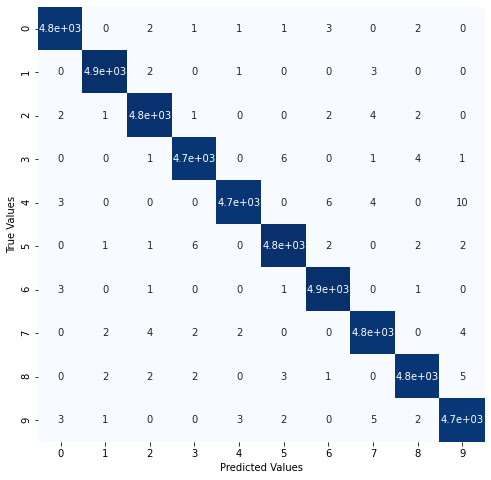

In [8]:
y_pred = np.argmax(model.predict(x_val), axis=1)

fig = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_val, y_pred).T, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.savefig('results/confusion-t1.png')

### OOD detection

<ipython-input-10-d2c8a6a36b3c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


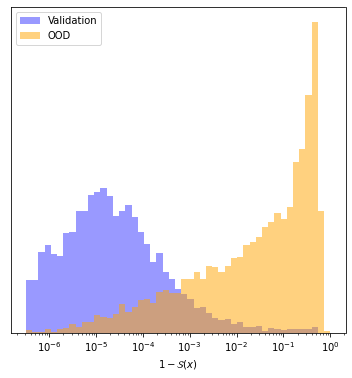

In [11]:
plot_hist(val_gen, ood_gen)
plt.savefig('results/mnist-hist-t1.png')

AUROC: 0.9373878173828126
FPR80: 0.10421874999999992
FPR90: 0.18015625000000002
FPR95: 0.36453125


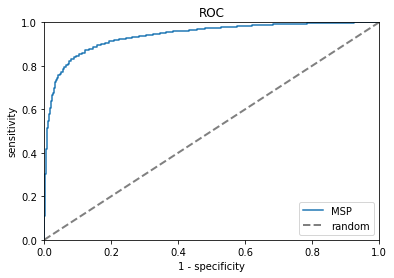

In [12]:
plot_roc()
plt.savefig('results/mnist-roc-t1.png')

<ipython-input-10-d2c8a6a36b3c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


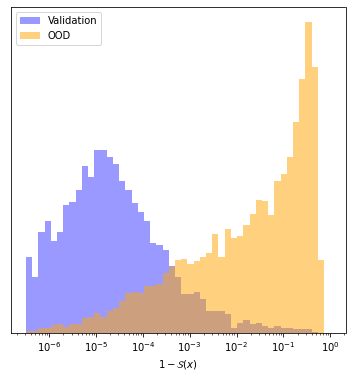

In [13]:
plot_hist(val_gen, ood_gen, epsilon=0.002)
plt.savefig('results/mnist-hist-t1-eps0.002.png')

AUROC: 0.9350011230468751
FPR80: 0.10359374999999993
FPR90: 0.18984374999999998
FPR95: 0.39937500000000004


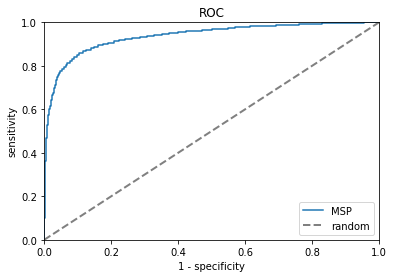

In [14]:
plot_roc(epsilon=0.002)
plt.savefig('results/mnist-roc-t1-eps0.002.png')

## ODIN (T=1000)

In [15]:
if TRAINING:
    model = get_model(1000)
    model = train_model(model, train_gen, val_gen)
else:
    model = keras.models.load_model('models/mnist-classifier-t1000.h5')
    model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 128)        

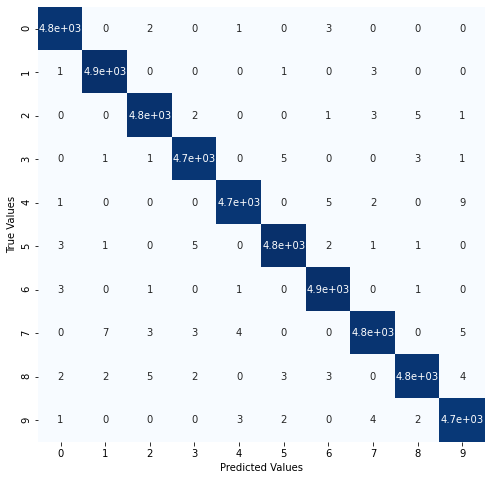

In [16]:
y_pred = np.argmax(model.predict(x_val), axis=1)

fig = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_val, y_pred).T, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.savefig('results/confusion-t1000.png')

<ipython-input-10-d2c8a6a36b3c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


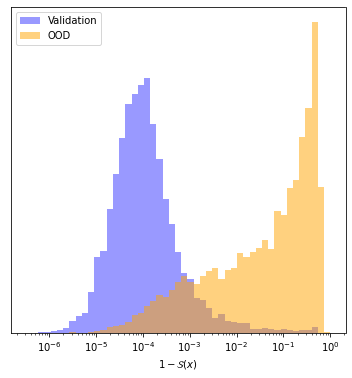

In [17]:
plot_hist(val_gen, ood_gen)
plt.savefig('results/mnist-hist-t1000.png')

AUROC: 0.9423919555664062
FPR80: 0.0831249999999999
FPR90: 0.1578124999999999
FPR95: 0.33406249999999993


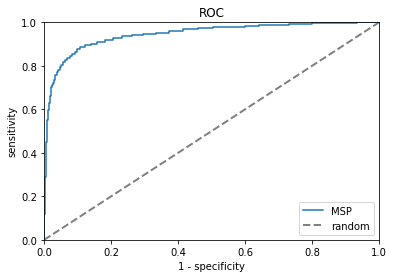

In [18]:
plot_roc()
plt.savefig('results/mnist-roc-t1000.png')

<ipython-input-10-d2c8a6a36b3c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


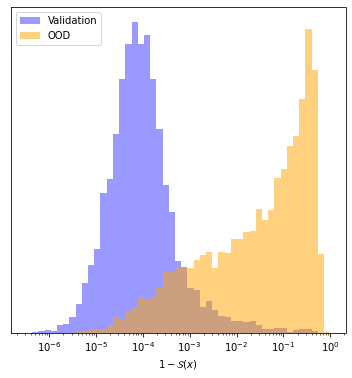

In [19]:
plot_hist(val_gen, ood_gen, epsilon=0.002)
plt.savefig('results/mnist-hist-t1000-eps0.002.png')

AUROC: 0.9438321411132813
FPR80: 0.07984374999999999
FPR90: 0.14140624999999996
FPR95: 0.2956249999999999


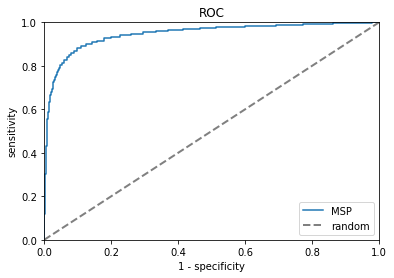

In [20]:
plot_roc(epsilon=0.002)
plt.savefig('results/mnist-roc-t1000-eps0.002.png')